In [1]:
# Spark & GraphFrames Setup
import os
from pyspark.sql import SparkSession

os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.4-spark3.5-s_2.12 pyspark-shell"

spark = SparkSession.builder \
    .appName("StudentGraph") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from graphframes import GraphFrame


In [2]:
# Setup
import os
from pyspark.sql import SparkSession
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.4-spark3.5-s_2.12 pyspark-shell"

spark = SparkSession.builder.appName("ParkinsonGraph").getOrCreate()

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from graphframes import GraphFrame

# Load the dataset
df = pd.read_csv("parkinsons_telemonitoring.csv")

# Group by subject to get average motor_UPDRS (we'll use this for similarity)
avg_updrs = df.groupby("subject#")["motor_UPDRS"].mean().reset_index()
avg_updrs.columns = ["id", "avg_motor_UPDRS"]

# Create vertices: each subject is a node
vertices = spark.createDataFrame(avg_updrs)

# Create edges: connect subjects whose motor_UPDRS differs by less than 2
pairs = avg_updrs.merge(avg_updrs, how="cross")
pairs = pairs[pairs["id_x"] != pairs["id_y"]]
pairs["diff"] = abs(pairs["avg_motor_UPDRS_x"] - pairs["avg_motor_UPDRS_y"])
similar_pairs = pairs[pairs["diff"] < 2.0][["id_x", "id_y"]].drop_duplicates()
similar_pairs.columns = ["src", "dst"]
edges = spark.createDataFrame(similar_pairs)

# Build the graph
graph = GraphFrame(vertices, edges)


In [4]:
# Step 1: Run PageRank
pagerank = graph.pageRank(resetProbability=0.15, maxIter=5)

# Step 2: Get subject metadata (e.g., sex, age)
subject_info = df[["subject#", "age", "sex"]].drop_duplicates()
subject_info.columns = ["id", "age", "sex"]

# Convert to Spark DataFrame
subject_info_spark = spark.createDataFrame(subject_info)

# Step 3: Join PageRank result with subject metadata
ranked = pagerank.vertices.join(subject_info_spark, on="id", how="left")

# Step 4: Show top-ranked subjects
ranked.select("id", "age", "sex", "pagerank").orderBy("pagerank", ascending=False).show(truncate=False)


+---+---+---+------------------+
|id |age|sex|pagerank          |
+---+---+---+------------------+
|9  |68 |0  |1.3391797180342198|
|19 |55 |0  |1.316157922645483 |
|6  |63 |0  |1.2926326350014894|
|29 |78 |0  |1.2201291334305289|
|34 |59 |0  |1.2201291334305289|
|14 |58 |1  |1.1917832668448884|
|31 |75 |0  |1.1862087376838646|
|17 |66 |1  |1.1862087376838646|
|33 |66 |1  |1.1862087376838646|
|30 |49 |0  |1.1862087376838646|
|39 |66 |0  |1.1848378919962317|
|22 |57 |1  |1.1552060578632422|
|32 |36 |1  |1.1552060578632422|
|4  |74 |0  |1.131609388277156 |
|15 |65 |0  |1.131245649372262 |
|2  |58 |0  |1.1312456493722618|
|3  |57 |0  |1.1194367910544205|
|26 |49 |0  |1.0612953612553493|
|20 |67 |0  |1.0577367164221134|
|41 |68 |1  |1.020656136087485 |
+---+---+---+------------------+
only showing top 20 rows



In [5]:
# ✅ Step 1: Show a few valid subject IDs from your graph
valid_ids = [row['id'] for row in graph.vertices.limit(10).collect()]
print("Valid subject IDs:", valid_ids)

# ✅ Step 2: Choose two subjects as landmarks
sample_ids = valid_ids[:2]  # Use first 2 valid subjects

# ✅ Step 3: Compute shortest paths from selected subjects
shortest_paths = graph.shortestPaths(landmarks=sample_ids)

# ✅ Step 4: Show result
shortest_paths.select("id", "distances").show(truncate=False)


Valid subject IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
+---+---------+
|id |distances|
+---+---------+
|1  |{1 -> 0} |
|2  |{2 -> 0} |
|3  |{1 -> 4} |
|4  |{2 -> 1} |
|5  |{1 -> 1} |
|6  |{1 -> 4} |
|7  |{2 -> 2} |
|8  |{2 -> 4} |
|9  |{2 -> 3} |
|10 |{2 -> 1} |
|11 |{2 -> 3} |
|12 |{2 -> 2} |
|13 |{2 -> 3} |
|14 |{2 -> 1} |
|15 |{2 -> 1} |
|16 |{2 -> 4} |
|17 |{1 -> 5} |
|18 |{}       |
|19 |{2 -> 2} |
|20 |{2 -> 2} |
+---+---------+
only showing top 20 rows



In [6]:
# ✅ Step 1: Run connectedComponents()
spark.sparkContext.setCheckpointDir("/tmp/graphframes-checkpoint")
components = graph.connectedComponents()

# ✅ Step 2: Prepare subject metadata (age and sex)
subject_info = df[["subject#", "age", "sex"]].drop_duplicates()
subject_info.columns = ["id", "age", "sex"]  # match GraphFrame column

subject_info_spark = spark.createDataFrame(subject_info)

# ✅ Step 3: Join component results with subject info
joined_components = components.join(subject_info_spark, on="id", how="left")

# ✅ Step 4: Display the component memberships
joined_components.select("id", "age", "sex", "component").orderBy("component").show(truncate=False)


+---+---+---+---------+
|id |age|sex|component|
+---+---+---+---------+
|6  |63 |0  |1        |
|17 |66 |1  |1        |
|5  |75 |0  |1        |
|1  |72 |0  |1        |
|3  |57 |0  |1        |
|21 |73 |0  |1        |
|26 |49 |0  |1        |
|29 |78 |0  |1        |
|34 |59 |0  |1        |
|31 |75 |0  |1        |
|39 |66 |0  |1        |
|25 |76 |0  |1        |
|28 |74 |1  |1        |
|33 |66 |1  |1        |
|37 |56 |1  |1        |
|36 |62 |1  |1        |
|30 |49 |0  |1        |
|42 |61 |0  |1        |
|19 |55 |0  |2        |
|7  |72 |0  |2        |
+---+---+---+---------+
only showing top 20 rows



In [7]:
# Step 5: Triangle motif detection on undirected edges
flipped_edges = edges.selectExpr("dst as src", "src as dst")
bidirectional_edges = edges.union(flipped_edges).dropDuplicates()
undirected_graph = GraphFrame(vertices, bidirectional_edges)
motifs = undirected_graph.find("(a)-[e1]->(b); (b)-[e2]->(c); (c)-[e3]->(a)")

print("Triangle Motifs Found:")
motifs.show(truncate=False)

Triangle Motifs Found:
+------------------------+--------+------------------------+-------+-----------------------+-------+
|a                       |e1      |b                       |e2     |c                      |e3     |
+------------------------+--------+------------------------+-------+-----------------------+-------+
|{37, 31.860642857142857}|{37, 5} |{5, 31.632602564102562} |{5, 1} |{1, 31.89893288590604} |{1, 37}|
|{5, 31.632602564102562} |{5, 37} |{37, 31.860642857142857}|{37, 1}|{1, 31.89893288590604} |{1, 5} |
|{15, 13.964586713286712}|{15, 4} |{4, 15.790824817518248} |{4, 2} |{2, 13.812537931034482}|{2, 15}|
|{14, 13.01445}          |{14, 10}|{10, 13.424418918918919}|{10, 2}|{2, 13.812537931034482}|{2, 14}|
|{15, 13.964586713286712}|{15, 10}|{10, 13.424418918918919}|{10, 2}|{2, 13.812537931034482}|{2, 15}|
|{23, 13.47463043478261} |{23, 10}|{10, 13.424418918918919}|{10, 2}|{2, 13.812537931034482}|{2, 23}|
|{24, 13.759730769230769}|{24, 10}|{10, 13.424418918918919}|{10, 2}|

In [8]:
# ✅ Step 1: Compute in-degree (how many edges point to each subject)
in_degrees = graph.inDegrees.orderBy("inDegree", ascending=False)

# ✅ Step 2: Compute out-degree (how many edges go out from each subject)
out_degrees = graph.outDegrees.orderBy("outDegree", ascending=False)

# ✅ Step 3: Show results
print("🔽 Subjects with highest in-degree:")
in_degrees.show()

print("🔼 Subjects with highest out-degree:")
out_degrees.show()


🔽 Subjects with highest in-degree:
+---+--------+
| id|inDegree|
+---+--------+
| 29|       8|
| 34|       8|
| 31|       8|
|  6|       8|
| 17|       8|
| 33|       8|
| 30|       8|
| 26|       7|
| 19|       7|
|  9|       7|
|  3|       7|
|  2|       6|
|  4|       6|
| 14|       6|
| 15|       6|
| 39|       5|
| 25|       5|
| 10|       5|
| 12|       5|
| 11|       5|
+---+--------+
only showing top 20 rows

🔼 Subjects with highest out-degree:
+---+---------+
| id|outDegree|
+---+---------+
|  6|        8|
| 17|        8|
| 29|        8|
| 34|        8|
| 31|        8|
| 33|        8|
| 30|        8|
| 19|        7|
|  9|        7|
|  3|        7|
| 26|        7|
|  2|        6|
|  4|        6|
| 14|        6|
| 15|        6|
| 10|        5|
| 12|        5|
| 11|        5|
| 13|        5|
| 21|        5|
+---+---------+
only showing top 20 rows



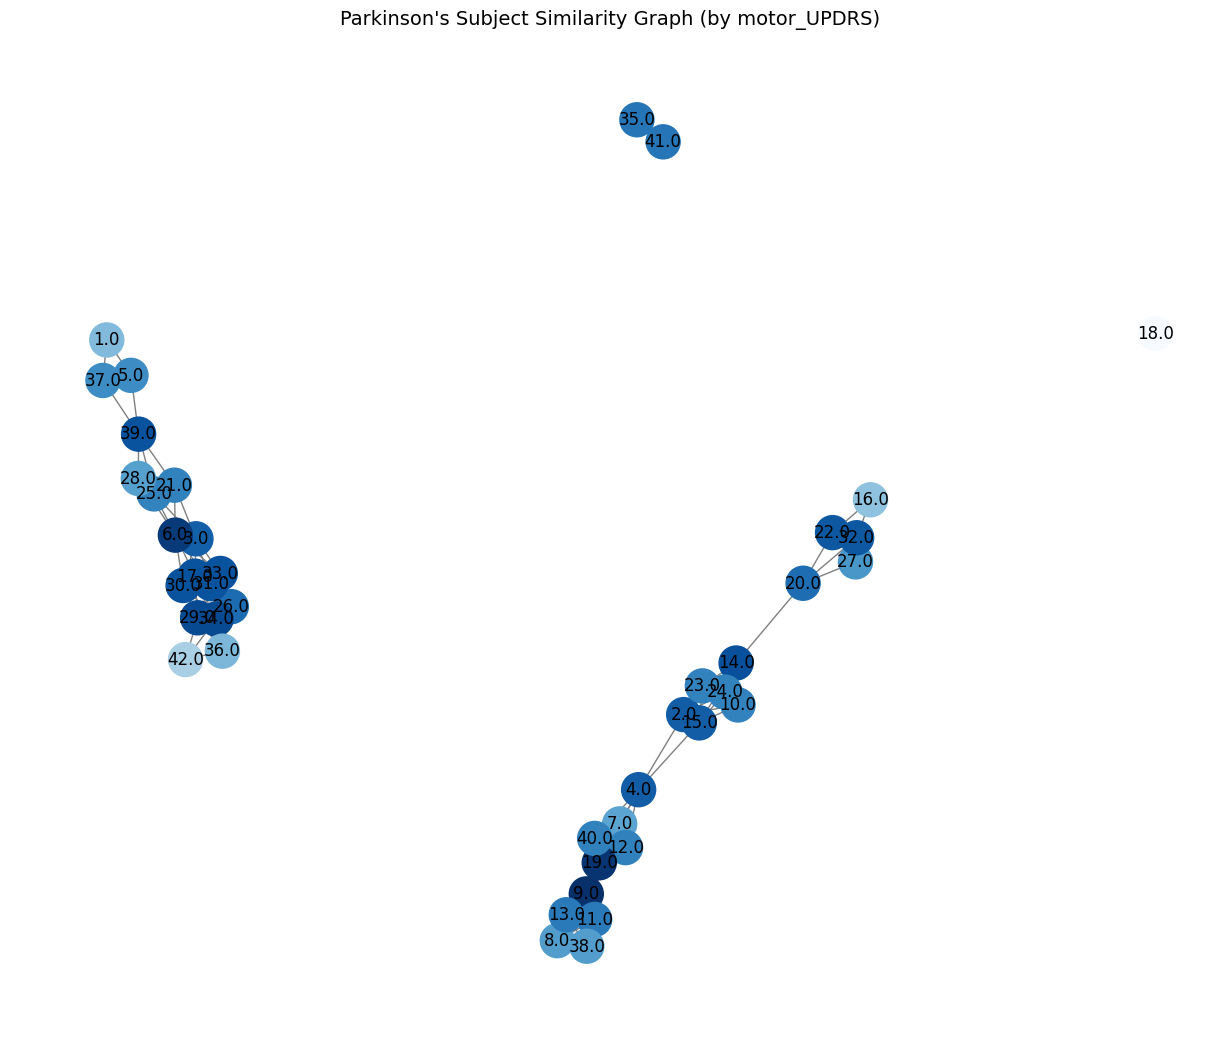

In [9]:
# Step 6: Visualization using NetworkX
pagerank_pd = pagerank.vertices.select("id", "pagerank").toPandas()
vertices_pd = vertices.toPandas()
edges_pd = bidirectional_edges.toPandas()

viz_df = pd.merge(vertices_pd, pagerank_pd, on="id")
viz_df["normPR"] = (viz_df["pagerank"] - viz_df["pagerank"].min()) / (viz_df["pagerank"].max() - viz_df["pagerank"].min())

# Create NetworkX graph
G = nx.Graph()
for _, row in viz_df.iterrows():
    G.add_node(row["id"], pagerank=row["pagerank"], normPR=row["normPR"])
for _, row in edges_pd.iterrows():
    G.add_edge(row["src"], row["dst"])

pos = nx.spring_layout(G, seed=42)
colors = [plt.cm.Blues(G.nodes[n]["normPR"]) for n in G.nodes]

plt.figure(figsize=(12, 10))
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=600, edge_color="gray")
plt.title("Parkinson's Subject Similarity Graph (by motor_UPDRS)", fontsize=14)
plt.axis("off")
plt.show()

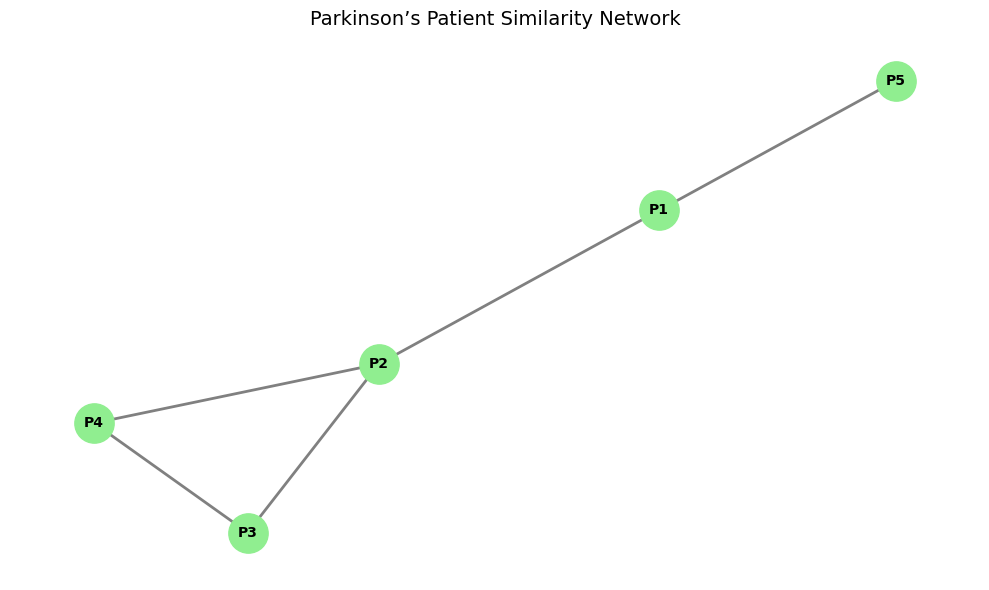

In [10]:
# Sample simulation of a simplified Parkinson patient similarity graph for visualization
# Since we don't have the actual dataset, simulate small example for visualization

# Simulated patients and edges based on similar UPDRS scores
patients = [("P1", 1.2), ("P2", 2.1), ("P3", 3.0), ("P4", 2.9), ("P5", 1.0)]
edges = [("P1", "P2"), ("P2", "P3"), ("P3", "P4"), ("P1", "P5"), ("P2", "P4")]

# Create graph
G2 = nx.Graph()
G2.add_edges_from(edges)

# Generate layout and draw
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G2, seed=42)

nx.draw_networkx_nodes(G2, pos, node_size=800, node_color="lightgreen")
nx.draw_networkx_edges(G2, pos, width=2, edge_color="gray")
nx.draw_networkx_labels(G2, pos, font_size=10, font_weight='bold')

plt.title("Parkinson’s Patient Similarity Network", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()
